In [13]:
# Initialize
import Pkg
Pkg.activate("../../juliaccel.jl/")  # Change to match your installation
using JuliAccel
using IJulia
using Plots
using LaTeXStrings
using LinearAlgebra
using Dates
using Printf
using Statistics

  Activating project at `~/Polybox/ETH/ParticleAcceleratorModelling/juliaccel.jl`


In [14]:

# Files
mad  = "pam-09.mad"
prob = "pam-09.japd"

mad_parsed = JuliAccel.parse_madx(mad)

prob_set = JuliAccel.extract_model_data(prob)

ekin = mad_parsed.beam["energy"]
particle = (mad_parsed.beam["particle"] == "electron") ? Electron() : Proton()

γ = get_gamma(ekin, particle.mass) 
β0 = get_beta(γ)
c = 3e8

P0 = γ * β0 * particle.mass/c # *1e6#/c


1.4819447344324965

### Function for calculating TWISS parameters from distribution

In [15]:
function calculate_twiss(Γ)
    if ndims(Γ) == 3        # Contains whole evolution
        x = copy(Γ[:,1,:])
        px = copy(Γ[:,2,:])
        dims4mean = 2
    elseif ndims(Γ) == 2    # contains only one instance in time
        x = Γ[1,:]
        px = Γ[2,:]
        dims4mean = 1
    end

    # Compute centered moments
    x_mean = mean(x, dims=dims4mean)
    x = x .- x_mean
    px_mean = mean(px, dims=dims4mean)
    px = px .- px_mean
        
    # Calculate second-order moments
    x_sq = mean(x.^2, dims=dims4mean)     # ⟨x²⟩
    px_sq = mean(px .^2, dims=dims4mean)   # ⟨p_x²⟩
    x_px = mean(x .* px, dims=dims4mean)  # ⟨x p_x⟩

    # Compute emittance and Twiss parameters
    epsilon = sqrt.(x_sq .* px_sq .- x_px .^ 2)  # RMS emittance
    beta_x = x_sq ./ epsilon
    alpha_x = -x_px ./ epsilon
    gamma_x = px_sq ./ epsilon

    # Validate Twiss parameter constraint: βγ - α² = 1
    @assert all(isapprox.(beta_x .* gamma_x .- alpha_x .^ 2, 1.0, atol=1e-6)) "Twiss parameters are inconsistent! βγ - α² != 1"

    return beta_x, alpha_x, gamma_x, epsilon
end

calculate_twiss (generic function with 1 method)

# Generate Maps from Hamiltonian

In [16]:
# Compute maps - Symplectic and Non-Symplectic
Ms = gen_maps(mad, prob, symplectic=true)
Mn = gen_maps(mad, prob, symplectic=false)


0.0%┣                                                ┫ 0/5 [00:00<00:00, -0s/it]
20.0%┣████████▋                                  ┫ 1/5 [00:03<Inf:Inf, InfGs/it]
40.0%┣███████████████████▏                            ┫ 2/5 [00:05<00:15, 5s/it]
60.0%┣████████████████████████████▉                   ┫ 3/5 [00:07<00:07, 4s/it]
80.0%┣██████████████████████████████████████▍         ┫ 4/5 [00:10<00:03, 3s/it]
100.0%┣███████████████████████████████████████████████┫ 5/5 [00:12<00:00, 3s/it]
100.0%┣███████████████████████████████████████████████┫ 5/5 [00:12<00:00, 3s/it]
0.0%┣                                                ┫ 0/5 [00:00<00:00, -0s/it]
20.0%┣████████▋                                  ┫ 1/5 [00:00<Inf:Inf, InfGs/it]
40.0%┣███████████████████▏                            ┫ 2/5 [00:01<00:03, 1it/s]
60.0%┣████████████████████████████▉                   ┫ 3/5 [00:01<00:01, 1it/s]
80.0%┣██████████████████████████████████████▍         ┫ 4/5 [00:02<00:01, 2it/s]
100.0%┣█████████████████████

5-element Vector{Vector{TaylorN{Float64}}}:
 [ 0.9999998250000051 x + 9.999999416666667e-7 px + 4.086918146751684e-7 x δ - 2.3353816619132065e-6 px δ + 2.7838169811533408e-14 x δ² - 3.181505121318104e-13 px δ² + 𝒪(‖x‖¹⁰),  - 0.3499999795833333 x + 0.9999998250000051 px - 4.768071449347799e-8 x δ + 4.086918146751684e-7 px δ + 2.783816981153341e-14 px δ² + 𝒪(‖x‖¹⁰),  1.0000001750000052 y + 1.0000000583333333e-6 py - 4.0869186235588287e-7 y δ - 2.335382206835658e-6 py δ + 2.7838169811533408e-14 y δ² + 3.181505121318104e-13 py δ² + 𝒪(‖x‖¹⁰),  0.35000002041666667 y + 1.0000001750000052 py - 4.768071449347799e-8 y δ - 4.0869186235588287e-7 py δ + 2.783816981153341e-14 py δ² + 𝒪(‖x‖¹⁰),  1.0 z + 4.454008779402466e-6 δ - 4.768071449347799e-8 x² + 4.0869179083481113e-7 x px - 1.1676908309566033e-6 px² - 4.768071449347799e-8 y² - 4.086918861962401e-7 y py - 1.167691103417829e-6 py² - 1.5602717458442453e-5 δ² + 1.1135267924613364e-13 x px δ - 3.181505121318104e-13 px² δ + 1.1135267924613364e-13 y

## Generate and Compare Matrices
Named variables like: 
- Ms = Map symplectic
- Mn = Map non-symplectic
- Rs = Matrix symplectic
- Rn = Matrix nonsymplectic 

These matrixes are **identical** to the matrices in the solution

In [17]:
# Focusing Quadrupole (half strength)
println("Focusing Quadrupole")
MsFoc = Ms[1]
MnFoc = Mn[1]
RsFoc = TaylorSeries.jacobian(MsFoc)
RnFoc = TaylorSeries.jacobian(MnFoc)
display(RsFoc)
#display(RnFoc)
# Drift Space
println("Drift Space")
MsDrift = Ms[2]
MnDrift = Mn[2]
RsDrift = TaylorSeries.jacobian(MsDrift)
RnDrift = TaylorSeries.jacobian(MnDrift)
display(RsDrift)
#display(RnDrift)
# Defocusing Quadrupole
println("Defocusing Quadrupole")
MsDefoc = Ms[3]
MnDefoc = Mn[3]
RsDefoc = TaylorSeries.jacobian(MsDefoc)
RnDefoc = TaylorSeries.jacobian(MnDefoc)
display(RsDefoc)
#display(RnDefoc)

@assert RsDrift == TaylorSeries.jacobian(Ms[4]) "Drifts are not the same..."
@assert RsFoc == TaylorSeries.jacobian(Ms[5]) "Focusing Quadrupoles are not the same"
println("Second Drift and Second Focusing Matrices are the same as above\n")

Rs = RsFoc * RsDrift * RsDefoc * RsDrift * RsFoc
Rn = RnFoc * RnDrift * RnDefoc * RnDrift * RnFoc
println("FODO Cell")
display(Rs)
display(Rn)

Focusing Quadrupole


6×6 transpose(::Matrix{Float64}) with eltype Float64:
  1.0   1.0e-6  0.0   0.0     0.0  0.0
 -0.35  1.0     0.0   0.0     0.0  0.0
  0.0   0.0     1.0   1.0e-6  0.0  0.0
  0.0   0.0     0.35  1.0     0.0  0.0
  0.0   0.0     0.0   0.0     1.0  4.45401e-6
  0.0   0.0     0.0   0.0     0.0  1.0

Drift Space


6×6 transpose(::Matrix{Float64}) with eltype Float64:
 1.0  0.6  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.6  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  2.67241
 0.0  0.0  0.0  0.0  0.0  1.0

Defocusing Quadrupole


6×6 transpose(::Matrix{Float64}) with eltype Float64:
 1.0  1.0e-6   0.0  0.0     0.0  0.0
 0.7  1.0      0.0  0.0     0.0  0.0
 0.0  0.0      1.0  1.0e-6  0.0  0.0
 0.0  0.0     -0.7  1.0     0.0  0.0
 0.0  0.0      0.0  0.0     1.0  4.45401e-6
 0.0  0.0      0.0  0.0     0.0  1.0

Second Drift and Second Focusing Matrices are the same as above

FODO Cell


6×6 Matrix{Float64}:
  0.9118   1.452    0.0      0.0       0.0  0.0
 -0.11613  0.9118   0.0      0.0       0.0  0.0
  0.0      0.0      0.9118   0.948002  0.0  0.0
  0.0      0.0     -0.17787  0.9118    0.0  0.0
  0.0      0.0      0.0      0.0       1.0  5.34482
  0.0      0.0      0.0      0.0       0.0  1.0

6×6 Matrix{Float64}:
  0.9118   1.452    0.0      0.0       0.0  0.0
 -0.11613  0.9118   0.0      0.0       0.0  0.0
  0.0      0.0      0.9118   0.948002  0.0  0.0
  0.0      0.0     -0.17787  0.9118    0.0  0.0
  0.0      0.0      0.0      0.0       1.0  5.34482
  0.0      0.0      0.0      0.0       0.0  1.0

## Generate Distribution
<font color='red'>The solution depends A LOT on the initial velocities of the particles</font>
- When changing to smaller or larger value, the solution looks very different
- Is it normal that the solution depends so much on the initial values?
- Shouldn't the solution be the most stable for small initial velocities?


In [18]:
# Generate Distribution
N_part = 1000 # number of particles

μ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
p_i = 5e-1     # Change to 1e-2 or 10 to get very different behavior. 
Σ = [16. 0.0 0.0 0.0 0.0 0.0;
     0.0 p_i 0.0 0.0 0.0 0.0;
     0.0 0.0 16. 0.0 0.0 0.0;
     0.0 0.0 0.0 p_i 0.0 0.0;
     0.0 0.0 0.0 0.0 0.709 0.0;
     0.0 0.0 0.0 0.0 0.0 0.0981]
D = Gaussian(μ, Σ)
Γi = gen_distribution(D, N_part)

# check emittance
ϵ = √(det(Σ[1:2, 1:2]))
empirical_Σ = cov(Γi[1:2,:]')
#println("Empirical Covariance Matrix: ", empirical_Σ)
println("Emittance from Empirical covariance Matrix: ", √(det(empirical_Σ[1:2, 1:2])))
println("Emittance from Matrix: ", ϵ)
twiss_initial = calculate_twiss(Γi)
println("Emittance from Distribution 2: ", twiss_initial[4])


Emittance from Empirical covariance Matrix: 2.881851464963412
Emittance from Matrix: 2.8284271247461903
Emittance from Distribution 2: [2.878969613498449]


## Propagate
Save whole phase-space as well as emittace of every type of map for each iteration

In [19]:
# Propagation:
N_iterations = 50
# objects holding phase space for each Iteration
Γs = Array{Float64, 3}(undef, N_iterations, size(μ)[1], N_part)
Γs[1,:,:] = Γi
Γn = copy(Γs)
Γsl = copy(Γs)  # Linear (with Matrix)
Γnl = copy(Γs)  # Linear (with Matrix)

for i ∈ 2:N_iterations
    for j ∈ 1:N_part
        Γs[i,:,j]  = MsFoc(MsDrift(MsDefoc(MsDrift(MsFoc( Γs[i-1,:,j] )))))
        Γn[i,:,j]  = MnFoc(MnDrift(MnDefoc(MnDrift(MnFoc( Γn[i-1,:,j] )))))
        Γsl[i,:,j] = Rs * Γsl[i-1,:,j]
        Γnl[i,:,j] = Rn * Γnl[i-1,:,j]
    end
end

# calculate TWISS parameters
TwissS = calculate_twiss(Γs)    # symplectic 
TwissN = calculate_twiss(Γn)    # nonsymplectic 
TwissSL = calculate_twiss(Γsl)  # symplectic linear
TwissNL = calculate_twiss(Γnl)  # nonsymplectic nonlinear

([5.72204752245207; 5.064878352851973; … ; 2.210570564329467; 2.571456441748838;;], [0.02302230327476477; 0.3896533867984181; … ; 0.08577621792142735; -0.31239796980965207;;], [0.17485524587522439; 0.22741508908992766; … ; 0.45570025034078315; 0.4268368982344977;;], [2.8789696134984473; 2.878969613498446; … ; 2.8789696134984664; 2.8789696134984673;;])

___
# Results

### Plot Cross-Section

[ Info: Saved animation to /home/jonas/Polybox/ETH/ParticleAcceleratorModelling/Exercises_PAM/Ex09/FODO-cross-section.gif


Plots.AnimatedGif("/home/jonas/Polybox/ETH/ParticleAcceleratorModelling/Exercises_PAM/Ex09/FODO-cross-section.gif")
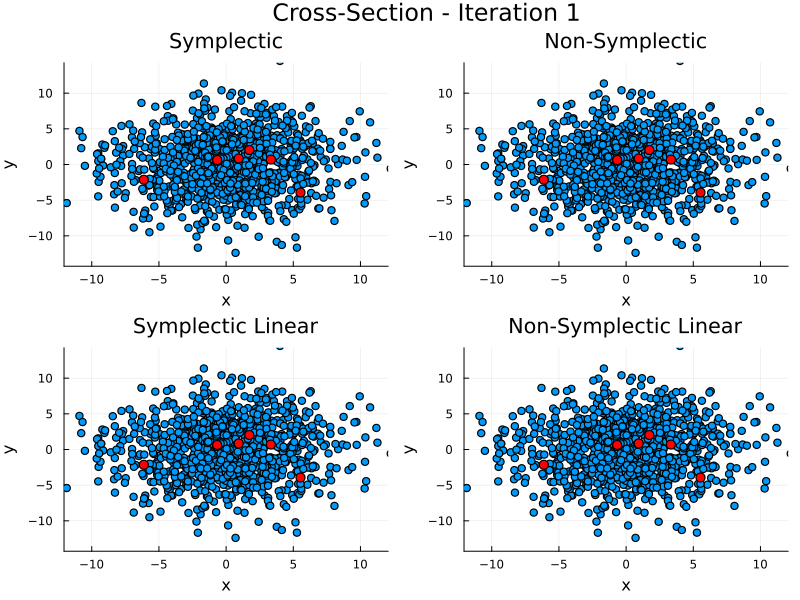

In [20]:
plot_layout = @layout [a b; c d]
limits_x = maximum(Γsl[end-5:end,1,:])
limits_y = maximum(Γsl[end-5:end,3,:])

crosssection = @animate for i ∈ 1:N_iterations
    p1 = scatter(Γs[i,1,:], Γs[i,3,:], title="Symplectic",    xlabel="x", ylabel="y", xlims=(-limits_x, limits_x), ylims=(-limits_y, limits_y))
    scatter!(p1, Γs[i,1,10:15], Γs[i,3,10:15], color=:red, markersize=5)
    p2 = scatter(Γn[i,1,:], Γn[i,3,:], title="Non-Symplectic",    xlabel="x", ylabel="y", xlims=(-limits_x, limits_x), ylims=(-limits_y, limits_y))
    scatter!(p2, Γn[i,1,10:15], Γn[i,3,10:15], color=:red, markersize=5)
    p3 = scatter(Γsl[i,1,:], Γsl[i,3,:], title="Symplectic Linear", xlabel="x", ylabel="y", xlims=(-limits_x, limits_x), ylims=(-limits_y, limits_y))
    scatter!(p3, Γsl[i,1,10:15], Γsl[i,3,10:15], color=:red, markersize=5)
    p4 = scatter(Γnl[i,1,:], Γnl[i,3,:], title="Non-Symplectic Linear", xlabel="x", ylabel="y", xlims=(-limits_x, limits_x), ylims=(-limits_y, limits_y))
    scatter!(p4, Γnl[i,1,10:15], Γnl[i,3,10:15], color=:red, markersize=5)

    plot(p1, p2, p3, p4, layout=plot_layout, size=(800, 600), suptitle="Cross-Section - Iteration $i", legend=false)
end
gif(crosssection, "FODO-cross-section.gif", fps=10)

# Questions:
- Are the fluctuations in the linear solution the betatron oscillations? 
- If so, why do these not occur in the nonlinear solution?


## Plot Phase-Space

[ Info: Saved animation to /home/jonas/Polybox/ETH/ParticleAcceleratorModelling/Exercises_PAM/Ex09/FODO-phase-space.gif


Plots.AnimatedGif("/home/jonas/Polybox/ETH/ParticleAcceleratorModelling/Exercises_PAM/Ex09/FODO-phase-space.gif")
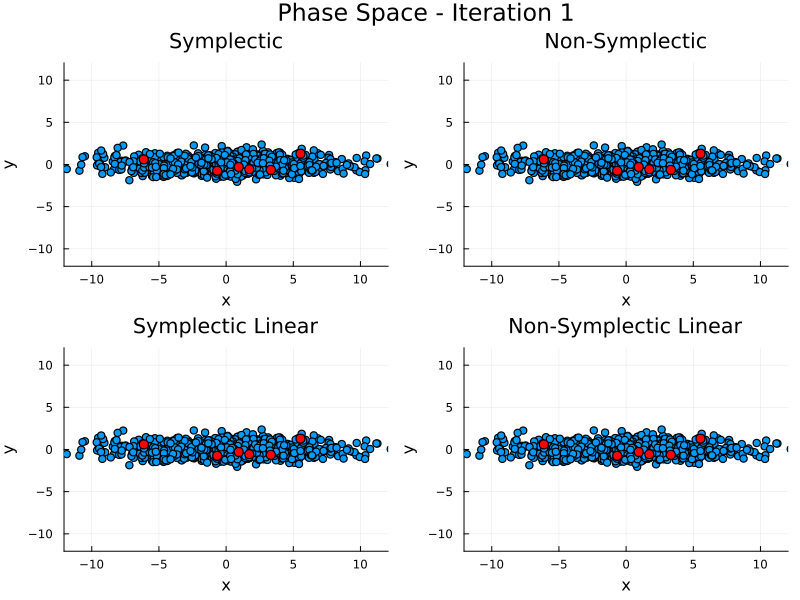

In [21]:
plot_layout = @layout [a b; c d]
limits_x = maximum(Γsl[end-5:end,1,:])
limits_y = maximum(Γsl[end-5:end,2,:])
limits_y = limits_x

phasespace = @animate for i ∈ 1:N_iterations    
    p1 = scatter(Γs[i,1,:], Γs[i,2,:], title="Symplectic",    xlabel="x", ylabel="y", xlims=(-limits_x, limits_x), ylims=(-limits_y, limits_y))
    scatter!(p1, Γs[i,1,10:15], Γs[i,2,10:15], color=:red, markersize=5)
    p2 = scatter(Γn[i,1,:], Γn[i,2,:], title="Non-Symplectic",    xlabel="x", ylabel="y", xlims=(-limits_x, limits_x), ylims=(-limits_y, limits_y))
    scatter!(p2, Γn[i,1,10:15], Γn[i,2,10:15], color=:red, markersize=5)
    p3 = scatter(Γsl[i,1,:], Γsl[i,2,:], title="Symplectic Linear", xlabel="x", ylabel="y", xlims=(-limits_x, limits_x), ylims=(-limits_y, limits_y))
    scatter!(p3, Γsl[i,1,10:15], Γsl[i,2,10:15], color=:red, markersize=5)
    p4 = scatter(Γnl[i,1,:], Γnl[i,2,:], title="Non-Symplectic Linear", xlabel="x", ylabel="y", xlims=(-limits_x, limits_x), ylims=(-limits_y, limits_y))
    scatter!(p4, Γnl[i,1,10:15], Γnl[i,2,10:15], color=:red, markersize=5)
    plot(p1, p2, p3, p4, layout=plot_layout, size=(800, 600), suptitle="Phase Space - Iteration $i", legend=false)
end
gif(phasespace, "FODO-phase-space.gif", fps=15)

# Questions:
- The nonlinear maps are **both** not symplectic.  
    - There is a huge jump right at the beginning of the simulation. See plot of $\epsilon$ below
- Only the linear phase space "rotates" as expected. Shouldn't the nonlinear solutions do this as well?

# Analyze TWISS Parameters
## $\beta_x$

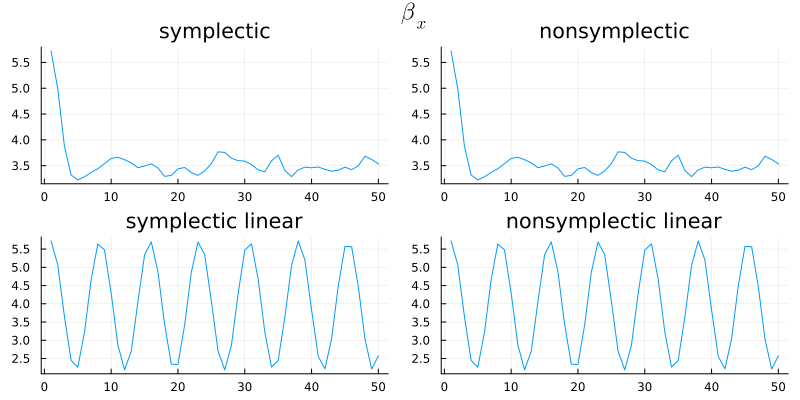

In [22]:
x = 1:N_iterations
plot_layout = @layout [a b ; c d]
a = plot(x, TwissS[1],  legend=false, title="symplectic")
b = plot(x, TwissN[1],  legend=false, title="nonsymplectic")
c = plot(x, TwissSL[1], legend=false, title="symplectic linear")
d = plot(x, TwissNL[1], legend=false, title="nonsymplectic linear")
plot(a, b, c, d, layout=plot_layout, size=(800, 400), suptitle=L"\beta_x")

# Questions:
- Are those the betatron oscillations for the linear solution?
- There is basically no difference between the symplectic and nonsymplectic linear solution
- The difference between the symplectic and nonsymplectic solutions is of order 1e-5. This is what I expected  

## $\epsilon_x$

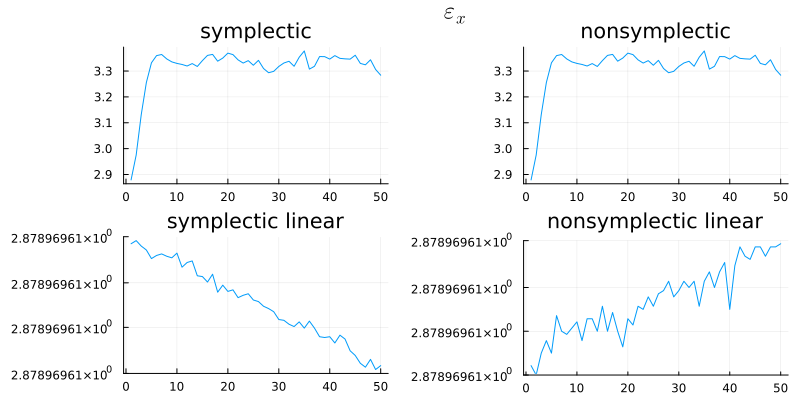

GKS: Possible loss of precision in routine SET_WINDOW


In [23]:
x = 1:N_iterations
plot_layout = @layout [a b ; c d]
a = plot(x, TwissS[4],  legend=false, title="symplectic")
b = plot(x, TwissN[4],  legend=false, title="nonsymplectic")
c = plot(x, TwissSL[4], legend=false, title="symplectic linear")
d = plot(x, TwissNL[4], legend=false, title="nonsymplectic linear")
plot(a, b, c, d, layout=plot_layout, size=(800, 400), suptitle=L"\epsilon_x")

# Questions
- The linear maps are both more symplectic than the nonlinear maps ???
- Am I doind something wrong?